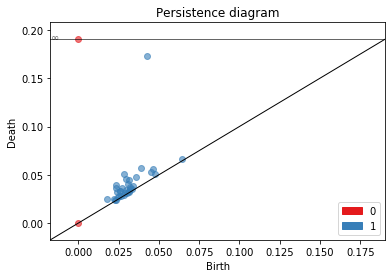

In [143]:
import matplotlib.pyplot as plot
import gudhi

# rips_on_tore3D_1307.pers obtained from write_persistence_diagram method
persistence_file='/home/bazyli/gitworkspace/gitBKrp/persistence/pcodebooks/rawdata/exp01_synthetic/pd_gauss_0_1/Circle/11.h5.pc.simba.1.00001_3.persistence'
a=gudhi.plot_persistence_diagram(persistence_file=persistence_file,
    legend=True)
plot.show()


In [187]:
import numpy as np
arr = gudhi.read_persistence_intervals_in_dimension(persistence_file, only_this_dim=1)

In [99]:
from gudhi.representations.preprocessing import BirthPersistenceTransform

In [188]:
arr = np.reshape(arr, (1,-1,2))

In [100]:
transformer = BirthPersistenceTransform()

In [191]:
arr = transformer.transform(arr)

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
class DiagramScaler(BaseEstimator, TransformerMixin):
    """
    This is a class for diagram transformation to be in range [0, 1] x [0, 1] with the respect 
    to maximum value of all (x, y) column of all given diagrams.
    """
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.all_diag_max = np.max(np.max(X, axis=1),axis=0)
        return self
    
    def transform(self, X):
        return X / self.all_diag_max


In [140]:
from sklearn.base import BaseEstimator, TransformerMixin
class RandomPDSampler(BaseEstimator, TransformerMixin):
    def __init__(self, max_points=None, weight_function=None):
        self.max_points = max_points
        self.weight_function = weight_function
        
        
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        out_diagram = np.concatenate(X)
        if not self.max_points:
            return [out_diagram]
        
        p = None
        if self.weight_function:
            persistencies = out_diagram[:,1]
            p = np.vectorize(self.weight_function)(persistencies)
            p /= np.sum(p)

        choice = np.random.choice(len(out_diagram), self.max_points, p=p, replace=False)
        
        return [out_diagram[choice]]
            
        

In [203]:
X = np.array(arr)

In [207]:
X = X.reshape((2,-1,2))

In [210]:
X.shape

(2, 17, 2)

In [220]:
ps = RandomPDSampler(3, lambda x: x**2)
ps.transform(X)

array([[0.0427533, 0.1304427],
       [0.0283355, 0.0229157],
       [0.0296474, 0.0163507]])

In [203]:
from sklearn.cluster import KMeans
import numpy as np
class PersistentBow(KMeans):
    def fit(self, X, y=None, sample_weight=None):
        X = np.concatenate(X)
        return super().fit(X, y, sample_weight)
    
    def predict(self, X, sample_weight=None):
        out = []
        for diagram in X:
            out.append(super().predict(diagram, sample_weight))
        return out
        

# Matlab data loading and processing

In [204]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [205]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [206]:
y = []
#TODO: format (dimension changing transformations)
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
X = data.T.reshape(-1)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [208]:
pipeline = Pipeline([
    ("name1", BirthPersistenceTransform()),
    #("name2", DiagramScaler()),
    ("name3", RandomPDSampler()),
    #("name4", PersistentBow(5))
])

pbow = PersistentBow(7)

In [209]:
pipeline.fit(X_train)
transformed = pipeline.transform(X_train)
pbow.fit(transformed)

PersistentBow(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
              n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
              random_state=None, tol=0.0001, verbose=0)

In [211]:
pbow.predict(X_train)

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1]),
 array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 6, 6]),
 array([1, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 6]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 6, 6, 3, 3, 6, 6, 6, 6, 3,
        6, 6, 6, 6, 6]),
 array([1, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 6]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 6, 6, 